In [1]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests as rq
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy

This function extracts MisProfesores.com data and returns a dataframe with that information. https://www.misprofesores.com/escuelas/UANL-FCFM_2263

In [3]:
def generate_table_prof(url: str) -> pd.DataFrame:
    web_mis_prof = rq.get(url)
    soup_mis_prof = bs(web_mis_prof.content, "html.parser")
    
    js_code = soup_mis_prof.find_all("script", type="text/javascript")
    str_dataset = re.search(r'var dataSet = (.*?);', str(js_code)).group(1)
    dataset = json.loads(str_dataset)
    df_prof = pd.DataFrame(dataset)
    df_prof.rename(columns={'i':"ID", 'n':"Name", 'a':"Last name(s)", 'd':"Department/Faculty", 'm':"Grades", 'c':"Mean"}, inplace=True)

    df_prof['Name']= df_prof['Name'].str.title()
    df_prof['Last name(s)']= df_prof['Last name(s)'].str.title()
    df_prof["Source"] =  df_prof["Name"] + '-' + df_prof["Last name(s)"] + '_' + df_prof["ID"] 
    df_prof["Source"] = "https://www.misprofesores.com/profesores/" + df_prof["Source"].str.replace(' ', '-')
    
    dic = []
    reco = []
    for prof_url in df_prof["Source"]:
        web_prof = rq.get(prof_url)
        soup_prof = bs(web_prof.content, "html.parser")

        reco_percent = soup_prof.find_all("div", attrs={"class": "grade"})[1].text
        reco_percent = reco_percent.replace(' ', '').replace('\n', '').replace('%', '')
        reco.append(reco_percent)

        difficulty = soup_prof.find_all("div", attrs={"class": "grade"})[2].text
        difficulty = difficulty.replace(' ', '').replace('\n', '').replace('%', '')
        dic.append(difficulty)

    df_prof["Recommendation"] = reco
    df_prof["Dificulty"] = dic

    df_prof = df_prof.reindex(columns=["ID", "Name", "Last name(s)", "Department/Faculty", "Grades", "Mean", "Recommendation", "Dificulty", "Source"])
    df_prof["Recommendation"]  = df_prof["Recommendation"].replace('',0)
    df_prof = df_prof.astype({"Grades":"int", "Mean":"float64", "Recommendation":"float64", "Dificulty":"float64"})
    # df_prof["Name"] = df_prof["Name"].title()
    return df_prof

This function returns a serie that contains all the reviews.

In [4]:
def generate_table_comments(urls: pd.Series) -> list:
    comments = []
    for url in urls: 
        web_prof = rq.get(url)
        soup_prof = bs(web_prof.content, "html.parser")
        num_grades = soup_prof.find("div", attrs={"class": "table-toggle rating-count active"}).text

        num_grades = num_grades.replace('\n', '').replace(' Calificaciones de Estudiantes', '')
        num_grades = num_grades.strip()

        if num_grades == '':
            num_grades = 0
        
        i = 1
        comments_prof = []
        while int(num_grades) > len(comments_prof ):
            web_prof = rq.get(url + "?pag={}".format(i))
            soup_prof = bs(web_prof.content, "html.parser")
            tags_comments = soup_prof.find_all("p", attrs={"class": "commentsParagraph"})
            for tag in tags_comments:
                tex = tag.text.replace('\n', '').replace('\r', '')
                tex = tex.strip()
                #if(tex != ''):
                comments_prof.append(tex)
            i = i+1
        comments.extend(comments_prof)

    comments = [c for c in comments if c != '']
    
    return comments

In [ ]:
df_fcfm = generate_table_prof("https://www.misprofesores.com/escuelas/UANL-FCFM_2263")

In [57]:
df_fcfm.to_csv("MisProfes.csv", index=False, encoding = 'utf-8-sig')

In [2]:
df = pd.read_csv("MisProfes.csv")

In [3]:
df

,ID,Name,Last name(s),Department/Faculty,Grades,Mean,Recommendation,Dificulty,Source
0,82556,Azucena Alejandra,Aceves Alós,UANL - FCFM (Actuaría),21,8.6190,90.0,0.6,https://www.misprofesores.com/profesores/Azuce...
1,159557,Daniel Raul,Acosta Martínez,FCFM,3,8.3333,100.0,2.7,https://www.misprofesores.com/profesores/Danie...
2,129020,Daniel Arturo,Acuña Leal,FCFM UANL,14,9.3571,86.0,2.0,https://www.misprofesores.com/profesores/Danie...
3,139018,Ester,Aguayo Moreno,Actuaría,2,7.0000,100.0,4.0,https://www.misprofesores.com/profesores/Ester...
4,96781,Martín,Aguilar,Fcfm,17,6.7059,59.0,1.1,https://www.misprofesores.com/profesores/Martí...
...,...,...,...,...,...,...,...,...,...
584,140196,Alberto,Zaldivar,FIC,0,NaN,0.0,10.0,https://www.misprofesores.com/profesores/Alber...
585,128837,Fisam,Zavala,Fcfm/Actuaria,14,9.7857,100.0,2.6,https://www.misprofesores.com/profesores/Fisam...
586,153396,Miguel Angel,Zavala Vizcaya,FCFM/LCC\t,1,8.0000,100.0,2.0,https://www.misprofesores.com/profesores/Migue...
587,117732,Raymundo Manuel,Zubieta Peña,LMAD,6,9.3333,100.0,3.3,https://www.misprofesores.com/profesores/Raymu...


In [4]:
df.describe()

,ID,Grades,Mean,Recommendation,Dificulty
count,589.000000,589.000000,528.000000,589.000000,589.000000
mean,116500.069610,9.473684,7.777210,66.925297,3.592869
std,31611.953185,12.784241,1.988987,37.304199,2.917724
min,26285.000000,0.000000,2.000000,0.000000,0.000000
25%,98016.000000,1.000000,6.666700,40.000000,1.400000
50%,114715.000000,4.000000,8.333300,83.000000,2.800000
75%,140051.000000,13.000000,9.358725,100.000000,5.100000
max,170962.000000,80.000000,10.000000,100.000000,10.000000


array([[<Axes: title={'center': 'Grades'}>]], dtype=object)

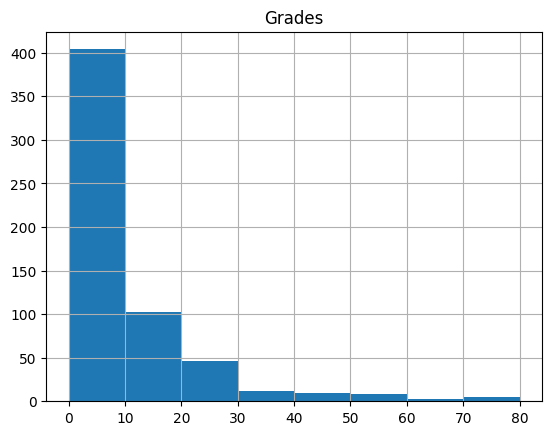

In [8]:
df.hist(["Grades"], bins=8)

array([[<Axes: title={'center': 'Mean'}>]], dtype=object)

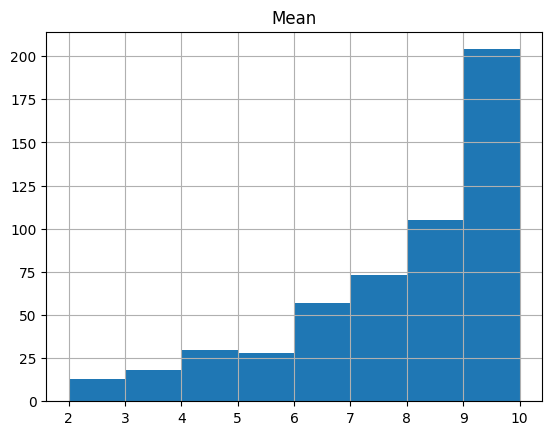

In [9]:
df.hist(["Mean"], bins=8)

array([[<Axes: title={'center': 'Recommendation'}>]], dtype=object)

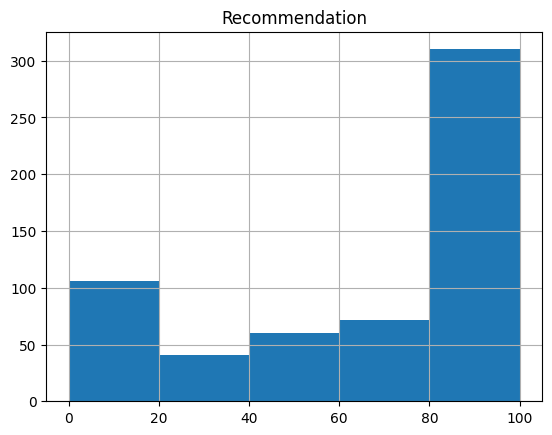

In [12]:
df.hist(["Recommendation"], bins=5)

array([[<Axes: title={'center': 'Dificulty'}>]], dtype=object)

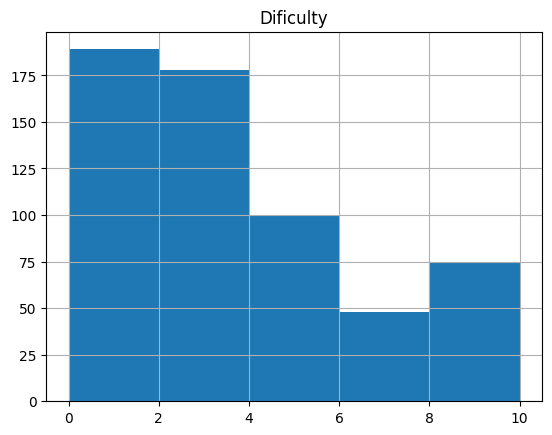

In [13]:
df.hist(["Dificulty"], bins=5)

## Comments analysis

In [11]:
df_fcfm_comments = generate_table_comments(df_fcfm["Source"])


In [13]:
df_fcfm_comments

4434

In [14]:
text = ". ".join(df_fcfm_comments)

In [4]:
text

'Realmente no de clase, reparte los temas entre los equipos y en base a eso da retroalimentación, super barco. Una gran maestra, pase con 10, solo es cuestión de hacer todo lo que pida la vdd creo que todo lo que pide es muy sencillo y ella es muy buena onda, te retroalimenta y platica cosas y da tips que nos pueden funcionar en unos años.. Es fácil pasar con ella y aprender mucho, pero eso sí la mayoría de los temas los impartirán en equipos, y también a veces pone a exponer en inglés.. Barcote. El semestre fue de presentaciones en equipo, el PIA también, lo que sí es que da platicas muy buenas acerca de la carrera, la asistencia se podría decir que es obligatoria ya que no graba las clases y a veces encarga trabajos en equipo para entregar en esa misma clase. Es buena, la mayoría de sus clases son platicadas, pero, muchas veces deja trabajos largos y aburridos, muchas exposiciones y tienes que participar. Se pone un poco estricta pero es bastante amigable y te saca platica a gusto.. 

In [28]:
with open("comentarios.txt", "a") as text_file:
    text_file.write(text)

In [1]:
with open('comentarios.txt', 'r') as file:
    text = file.read()

In [2]:
text

'Realmente no de clase, reparte los temas entre los equipos y en base a eso da retroalimentación, super barco. Una gran maestra, pase con 10, solo es cuestión de hacer todo lo que pida la vdd creo que todo lo que pide es muy sencillo y ella es muy buena onda, te retroalimenta y platica cosas y da tips que nos pueden funcionar en unos años.. Es fácil pasar con ella y aprender mucho, pero eso sí la mayoría de los temas los impartirán en equipos, y también a veces pone a exponer en inglés.. Barcote. El semestre fue de presentaciones en equipo, el PIA también, lo que sí es que da platicas muy buenas acerca de la carrera, la asistencia se podría decir que es obligatoria ya que no graba las clases y a veces encarga trabajos en equipo para entregar en esa misma clase. Es buena, la mayoría de sus clases son platicadas, pero, muchas veces deja trabajos largos y aburridos, muchas exposiciones y tienes que participar. Se pone un poco estricta pero es bastante amigable y te saca platica a gusto.. 

In [5]:
# Cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm') #python -m spacy download es_core_news_sm

# Procesar la oración con spaCy
doc = nlp(text)

# Identificar sustantivos
sustantivos = [token.text for token in doc if token.pos_ == 'NOUN' or token.pos_ == 'ADJ']

# Imprimir los sustantivos identificados
print("Sustantivos en la oración:", sustantivos)

Sustantivos en la oración: ['clase', 'temas', 'equipos', 'base', 'retroalimentación', 'super', 'barco', 'gran', 'maestra', 'solo', 'cuestión', 'vdd', 'sencillo', 'buena', 'onda', 'platica', 'cosas', 'tips', 'años', 'fácil', 'mayoría', 'temas', 'equipos', 'veces', 'inglés', 'semestre', 'presentaciones', 'equipo', 'platicas', 'buenas', 'carrera', 'asistencia', 'obligatoria', 'clases', 'veces', 'trabajos', 'equipo', 'clase', 'buena', 'mayoría', 'clases', 'veces', 'trabajos', 'largos', 'aburridos', 'exposiciones', 'amigable', 'platica', 'gusto', 'clase', 'temas', 'equipo', 'trato', 'compañeros', 'pésimas', 'presentaciones', 'final', 'bPor', 'barco', 'carrera', 'general', 'buena', 'profe', ':))', 'amor', 'persona', 'carrera', 'duda', 'SEMESTRE', 'buena', 'profe', 'curso', 'presentaciones', 'temas', 'clase', 'interesante', 'profe', 'retroalimentacion', 'materia', 'facil', 'buena', 'explicación', 'clases', 'Maestra', 'super', 'recomendada', 'ademas', 'coordinadora', 'buena', 'hora', 'clase', 

In [6]:
join_sust = " ".join(sustantivos)

In [7]:
join_sust

'clase temas equipos base retroalimentación super barco gran maestra solo cuestión vdd sencillo buena onda platica cosas tips años fácil mayoría temas equipos veces inglés semestre presentaciones equipo platicas buenas carrera asistencia obligatoria clases veces trabajos equipo clase buena mayoría clases veces trabajos largos aburridos exposiciones amigable platica gusto clase temas equipo trato compañeros pésimas presentaciones final bPor barco carrera general buena profe :)) amor persona carrera duda SEMESTRE buena profe curso presentaciones temas clase interesante profe retroalimentacion materia facil buena explicación clases Maestra super recomendada ademas coordinadora buena hora clase nada tediosas excelente maestra consejos futuro linea actividades clase aprendido estricto proyecto final fuera temas mensaje antelación clases dinámicas ejercicios haces replicarlos resto clase dudas retroalimentación avances mejor mejor buscas probable visto flexible aspectos proyectos tareas tema

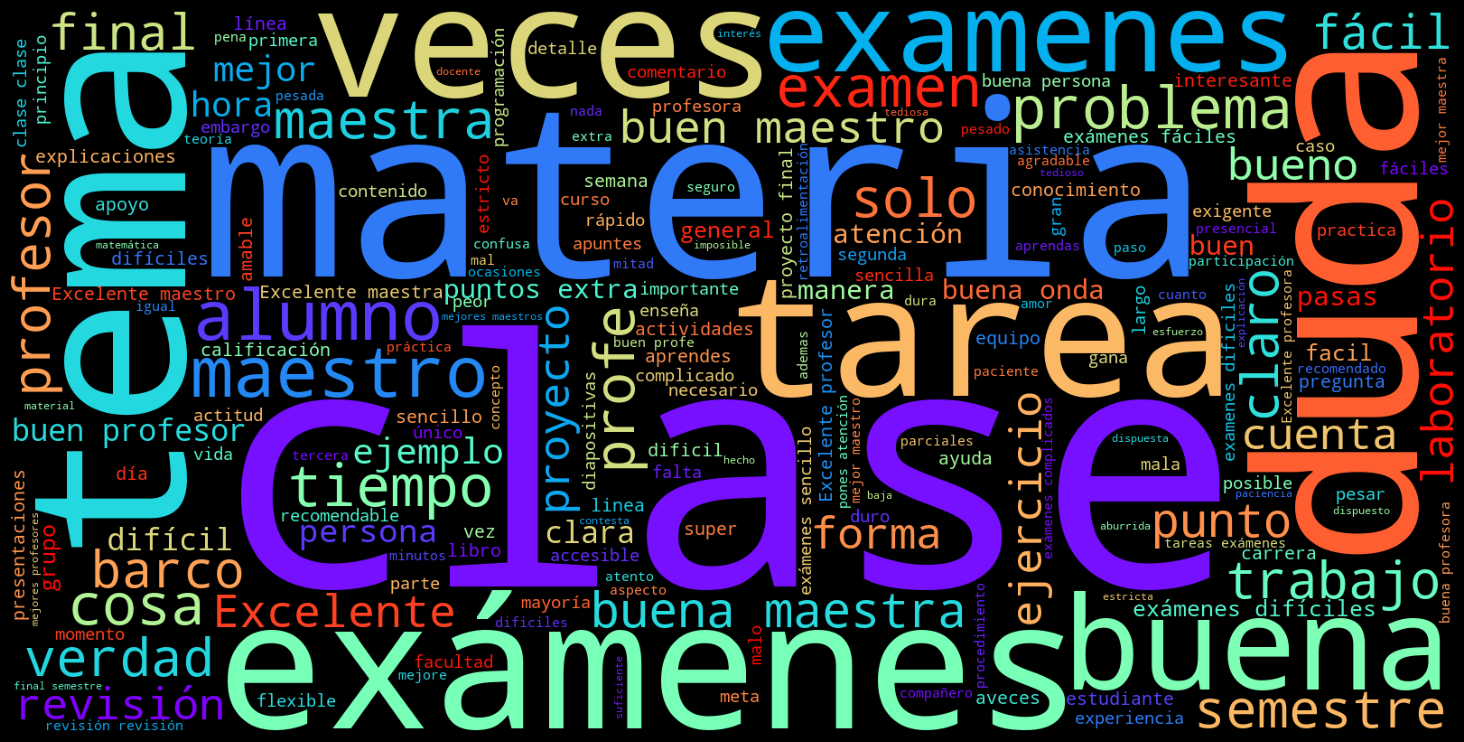

In [41]:
wc = WordCloud(width = 1600, height = 800, background_color = "black",
               colormap = "rainbow").generate(join_sust)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=10)
plt.savefig(route + "Word Cloud FCFM.png", facecolor='k')